# Data loading and exploration

In [1]:
import optuna
import torch
import os
import re
import scipy.io as sio
from glob import glob
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
from torch.utils.data import Dataset, DataLoader

def load_one(file_path, V_rms):
    if not os.path.exists(file_path):
        raise FileNotFoundError(file_path)

    # --- extract metadata from filename ---
    fname = os.path.basename(file_path)
    # Example: sweep_50_500K_9000_1v_t10920_25.8.mat
    m = re.match(r"sweep_(\d+)_([\d\.]+)K_\d+_([\d\.]+)v_t(\d+)_([\d\.]+)\.mat", fname)
    if not m:
        raise ValueError(f"Unexpected filename format: {fname}")
    start_freq = float(m.group(1))
    stop_freq = float(m.group(2)) * 1e3  # convert K→Hz
    stim_voltage = float(m.group(3))
    weight = float(m.group(4)) / 100      # 10920 → 109.20 g
    temperature = float(m.group(5))


    # --- load .mat ---
    S = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)
    fn = [k for k in S.keys() if not k.startswith("__")]
    dev = getattr(S[fn[0]], "demods", None)
    if dev is None or not hasattr(dev, "sample"):
        raise KeyError(f"No dev.demods.sample in {file_path}")

    s = dev.sample
    if isinstance(s, (list, np.ndarray)) and len(s) > 0:
        s = s[0]

    f = np.array(s.frequency, dtype=float)
    X = np.array(s.x, dtype=float)
    Y = np.array(s.y, dtype=float)

    # Complex current and impedance
    I = X + 1j * Y
    I_mag = np.abs(I)
    epsI = max(np.max(I_mag) * 1e-12, 1e-18)
    I[I_mag < epsI] = epsI

    Z = V_rms / I
    R = np.real(Z)
    Xc = np.imag(Z)
    Zmag = np.abs(Z)
    Zphase = np.degrees(np.angle(Z))

    return {
        "file": file_path,
        "f": f,
        "R": R,
        "Xc": Xc,
        "Zmag": Zmag,
        "Zphase": Zphase,
        "weight_g": weight,
        "temperature_C": temperature,
        "V_rms": V_rms,
        "start_freq": start_freq,
        "stop_freq": stop_freq,
        "stim_voltage": stim_voltage,
    }

# Example usage
data_dir = r"Datafolder"
files = glob(os.path.join(data_dir, "*.mat"))

datasets = [
    load_one(f, V_rms=1.0)
    for f in files
]

# Organize datasets by weight, starting with the highest weight
datasets = sorted(datasets, key=lambda x: x["weight_g"], reverse=True)

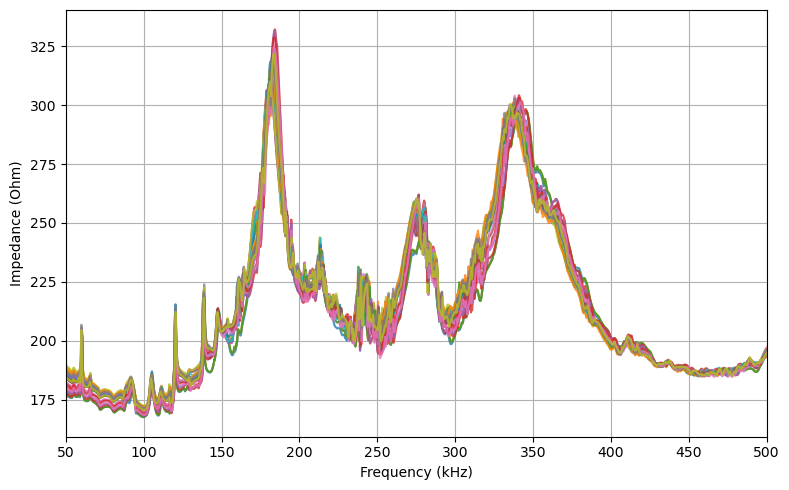

In [2]:
plt.figure(figsize=(8, 5))
for d in datasets:
    label = f"{d['temperature_C']}°C, {d['weight_g']:.2f}g"
    plt.plot(d["f"] / 1000, d["R"], label=f"R - {label}", alpha=0.8)
    #plt.plot(d["f"] / 1000, d["Xc"], linestyle="--", label=f"Xc - {label}", alpha=0.8)

plt.xlim(50, 500)
#plt.xlim(150, 200)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance (Ohm)")
#plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

Available weights: [109.2, 109.4, 109.65, 109.9, 110.1, 110.3, 110.5, 110.7, 110.9, 111.1, 111.3, 111.5, 111.7, 111.9, 112.05, 112.25, 112.5, 112.7, 112.9, 113.1, 113.3, 113.5, 113.7, 113.9, 114.1, 114.3, 114.8, 114.8, 115.0]


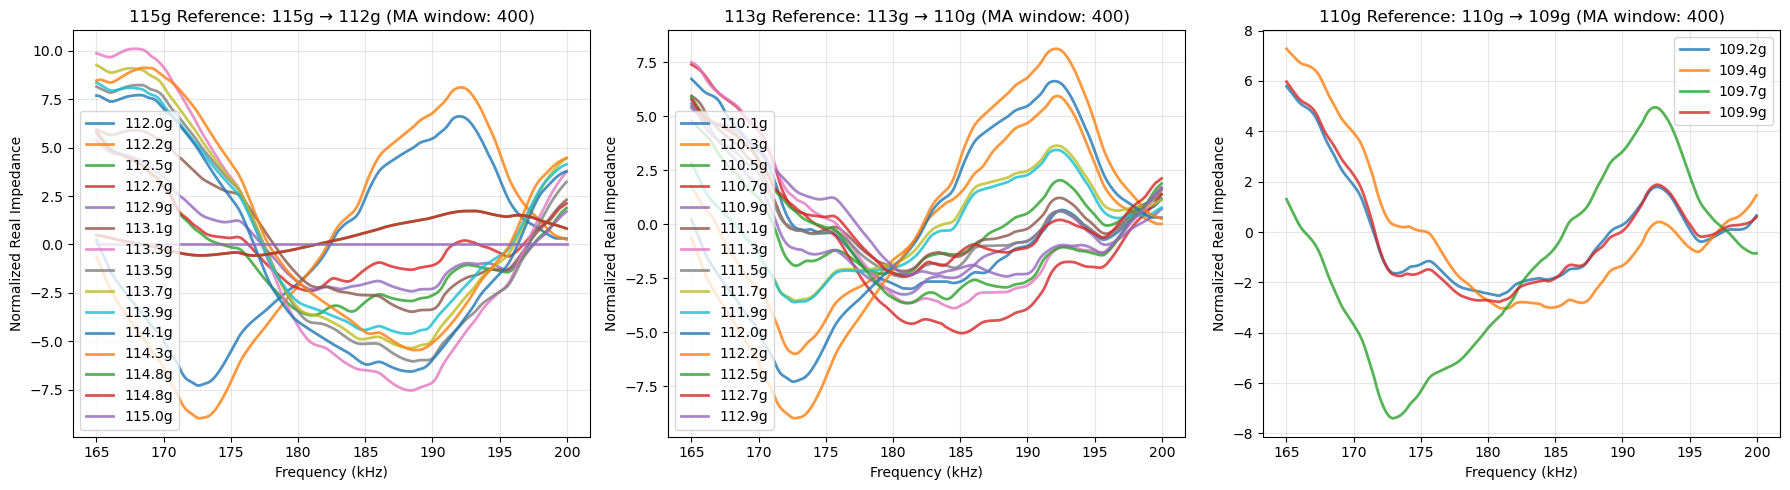

In [24]:
# Analysis of impedance changes across damage steps
# Compare if impedance change from 115g->114g is similar to 110g->109g, etc.

import matplotlib.pyplot as plt
import numpy as np

# Sort datasets by weight for proper sequential analysis
datasets_sorted = sorted(datasets, key=lambda x: x["weight_g"])

# Extract weights and calculate weight steps
weights = [d["weight_g"] for d in datasets_sorted]
print(f"Available weights: {weights}")

# Define frequency range for analysis (using the same range as your ML pipeline)
freq_start_khz = 165
freq_stop_khz = 200

# Moving average filter parameters - adjust as needed
moving_avg_window = 400  # Window size for moving average filter (1 = no filtering)


def apply_moving_average(data, window_size):
    """Apply moving average filter to data"""
    if window_size <= 1:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Calculate impedance changes between consecutive weight steps
weight_changes = []
impedance_changes = []
reference_impedances = []

for i in range(len(datasets_sorted) - 1):
    current_data = datasets_sorted[i]
    next_data = datasets_sorted[i + 1]
    
    # Apply moving average filter first, then frequency filter
    R_curr_filtered = apply_moving_average(current_data["R"], moving_avg_window)
    R_next_filtered = apply_moving_average(next_data["R"], moving_avg_window)
    
    # Filter frequency range for both datasets
    freq_khz_curr = current_data["f"] / 1000
    freq_khz_next = next_data["f"] / 1000
    
    freq_mask_curr = (freq_khz_curr >= freq_start_khz) & (freq_khz_curr <= freq_stop_khz)
    freq_mask_next = (freq_khz_next >= freq_start_khz) & (freq_khz_next <= freq_stop_khz)
    
    R_curr = R_curr_filtered[freq_mask_curr]
    R_next = R_next_filtered[freq_mask_next]
    
    # Calculate the change in impedance (absolute and relative)
    delta_weight = next_data["weight_g"] - current_data["weight_g"]
    delta_R_abs = np.mean(R_next - R_curr)  # Mean absolute change
    delta_R_rel = np.mean((R_next - R_curr) / R_curr) * 100  # Mean relative change in %
    
    weight_changes.append(f"{current_data['weight_g']:.1f}g → {next_data['weight_g']:.1f}g")
    impedance_changes.append({
        'weight_step': delta_weight,
        'abs_change': delta_R_abs,
        'rel_change': delta_R_rel,
        'from_weight': current_data['weight_g'],
        'to_weight': next_data['weight_g']
    })
    reference_impedances.append(np.mean(R_curr))

# Create 3 plots with specific weight ranges
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: 115g reference, show 115g to 112g
# Find 115g dataset as reference
ref_115 = None
for d in datasets_sorted:
    if abs(d['weight_g'] - 115.0) < 0.1:
        ref_115 = d
        break

if ref_115:
    # Apply moving average filter first, then frequency filter
    R_ref1_filtered = apply_moving_average(ref_115["R"], moving_avg_window)
    freq_khz_ref1 = ref_115["f"] / 1000
    freq_mask_ref1 = (freq_khz_ref1 >= freq_start_khz) & (freq_khz_ref1 <= freq_stop_khz)
    R_ref1 = R_ref1_filtered[freq_mask_ref1]
    
    for d in datasets_sorted:
        if 112.0 <= d['weight_g'] <= 115.0:
            # Apply moving average filter first, then frequency filter
            R_filtered = apply_moving_average(d["R"], moving_avg_window)
            freq_khz = d["f"] / 1000
            freq_mask = (freq_khz >= freq_start_khz) & (freq_khz <= freq_stop_khz)
            R_normalized = R_filtered[freq_mask] - R_ref1
            
            ax1.plot(freq_khz[freq_mask], R_normalized, 
                    label=f'{d["weight_g"]:.1f}g', alpha=0.8, linewidth=2)

ax1.set_xlabel('Frequency (kHz)')
ax1.set_ylabel('Normalized Real Impedance')
ax1.set_title(f'115g Reference: 115g → 112g (MA window: {moving_avg_window})')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: 113g reference, show 113g to 110g
ref_113 = None
for d in datasets_sorted:
    if abs(d['weight_g'] - 113.0) < 0.1:
        ref_113 = d
        break

if ref_113:
    # Apply moving average filter first, then frequency filter
    R_ref2_filtered = apply_moving_average(ref_113["R"], moving_avg_window)
    freq_khz_ref2 = ref_113["f"] / 1000
    freq_mask_ref2 = (freq_khz_ref2 >= freq_start_khz) & (freq_khz_ref2 <= freq_stop_khz)
    R_ref2 = R_ref2_filtered[freq_mask_ref2]
    
    for d in datasets_sorted:
        if 110.0 <= d['weight_g'] <= 113.0:
            # Apply moving average filter first, then frequency filter
            R_filtered = apply_moving_average(d["R"], moving_avg_window)
            freq_khz = d["f"] / 1000
            freq_mask = (freq_khz >= freq_start_khz) & (freq_khz <= freq_stop_khz)
            R_normalized = R_filtered[freq_mask] - R_ref1
            
            ax2.plot(freq_khz[freq_mask], R_normalized, 
                    label=f'{d["weight_g"]:.1f}g', alpha=0.8, linewidth=2)

ax2.set_xlabel('Frequency (kHz)')
ax2.set_ylabel('Normalized Real Impedance')
ax2.set_title(f'113g Reference: 113g → 110g (MA window: {moving_avg_window})')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: 110g reference, show 110g to 109g
ref_110 = None
for d in datasets_sorted:
    if abs(d['weight_g'] - 110.0) < 0.1:
        ref_110 = d
        break

if ref_110:
    # Apply moving average filter first, then frequency filter
    R_ref3_filtered = apply_moving_average(ref_110["R"], moving_avg_window)
    freq_khz_ref3 = ref_110["f"] / 1000
    freq_mask_ref3 = (freq_khz_ref3 >= freq_start_khz) & (freq_khz_ref3 <= freq_stop_khz)
    R_ref3 = R_ref3_filtered[freq_mask_ref3]
    
    for d in datasets_sorted:
        if 109.0 <= d['weight_g'] <= 110.0:
            # Apply moving average filter first, then frequency filter
            R_filtered = apply_moving_average(d["R"], moving_avg_window)
            freq_khz = d["f"] / 1000
            freq_mask = (freq_khz >= freq_start_khz) & (freq_khz <= freq_stop_khz)
            R_normalized = R_filtered[freq_mask] - R_ref1
            
            ax3.plot(freq_khz[freq_mask], R_normalized, 
                    label=f'{d["weight_g"]:.1f}g', alpha=0.8, linewidth=2)

ax3.set_xlabel('Frequency (kHz)')
ax3.set_ylabel('Normalized Real Impedance')
ax3.set_title(f'110g Reference: 110g → 109g (MA window: {moving_avg_window})')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

# ML Pipeline

## 0. Config

In [ ]:
# Frequency range parameters (in kHz) for feature extraction
freq_start_khz = 165   # Change this to set start frequency
freq_stop_khz = 200    # Change this to set stop frequency

study_focus = "RealTemp"

# Study configuration
study_name = f"impedance_optimization_{study_focus}_{freq_start_khz}_{freq_stop_khz}kHz"
storage_url = "sqlite:///optuna_study.db"

fig_folder = f"figures/{study_focus}"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

TUNA_TRAILS = 300
NUM_OF_EPOCHS = 300
N_TRAINING_RUNS = 10  # Number of times to train the model


# Load existing study
study = optuna.create_study(
    study_name=study_name,
    storage=storage_url,
    direction="minimize",
    load_if_exists=True
)

[I 2025-10-22 16:10:19,651] Using an existing study with name 'impedance_optimization_RealTemp_165_200kHz' instead of creating a new one.


## 1. Data prep

In [25]:
# Build dataset matrix
freqs = datasets[0]["f"]
X_data, y_data = [], []

# Get reference values from first dataset for normalization
freq_khz_ref = datasets[0]["f"] / 1000
freq_mask_ref = (freq_khz_ref >= freq_start_khz) & (freq_khz_ref <= freq_stop_khz)
R_ref = datasets[0]["R"][freq_mask_ref]
Xc_ref = datasets[0]["Xc"][freq_mask_ref]

for d in datasets:
    # Filter data by frequency range
    freq_khz = d["f"] / 1000
    freq_mask = (freq_khz >= freq_start_khz) & (freq_khz <= freq_stop_khz)
    
    R = d["R"][freq_mask]
    Xc = d["Xc"][freq_mask]
    temp = d["temperature_C"]
    
    # Normalize R and Xc by dividing by the first dataset values
    R_normalized = R / R_ref
    Xc_normalized = Xc / Xc_ref
    
    # feature vector, change trainning data
    # --------------------------------------
    features = np.concatenate([R_normalized, [temp]])
    # --------------------------------------

    X_data.append(features)
    y_data.append(d["weight_g"] - 115.0)  # target: delta weight

X_data = np.array(X_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32).reshape(-1, 1)

# Normalize features (zero mean, unit variance)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

## 2. Pytorch dataset

In [26]:
class ImpedanceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ImpedanceDataset(X_data, y_data)


## 3. Train/Validate split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
train_ds = ImpedanceDataset(X_train, y_train)
val_ds = ImpedanceDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

## 4. Define model

In [34]:
class ImpedanceNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, kernel_size, stride, dropout):
        super().__init__()
        self.input_dim = input_dim
        
        # Calculate dimensions after conv layers
        def conv_output_size(input_size, kernel_size, stride, padding):
            return (input_size + 2 * padding - kernel_size) // stride + 1
        
        # First conv layer
        padding1 = kernel_size // 2
        size_after_conv1 = conv_output_size(input_dim, kernel_size, stride, padding1)
        
        # Second conv layer  
        size_after_conv2 = conv_output_size(size_after_conv1, kernel_size, stride, padding1)
        
        # Third conv layer
        size_after_conv3 = conv_output_size(size_after_conv2, kernel_size, stride, padding1)
        
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(1, hidden_channels, kernel_size, stride=stride, padding=padding1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv1d(hidden_channels, hidden_channels*2, kernel_size, stride=stride, padding=padding1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv1d(hidden_channels*2, hidden_channels*4, kernel_size, stride=stride, padding=padding1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout)
        )
        
        # Calculate final feature size
        final_features = hidden_channels * 4 * size_after_conv3
        self.fc = torch.nn.Linear(final_features, 1)
        
    def forward(self, x):
        # x shape: (batch, features) -> (batch, 1, features)
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.flatten(1)
        return self.fc(x)

## 5. Optuna hyperparam search

In [35]:
# Check CUDA availability and GPU information
print("CUDA Setup Information:")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("CUDA not available - will use CPU for training")
print()

CUDA Setup Information:
CUDA Available: True
CUDA Version: 11.8
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 4090
GPU Memory: 25.8 GB



In [ ]:
def objective(trial):
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Hyperparameters to optimize
    hidden_channels = trial.suggest_int("hidden_channels", 4, 128)
    kernel_size = trial.suggest_int("kernel_size", 3, 40, step=2)
    stride = trial.suggest_int("stride", 1, 40) 
    dropout = trial.suggest_float("dropout", 0.0, 1)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=False)
    epochs = NUM_OF_EPOCHS

    try:
        model = ImpedanceNet(X_train.shape[1], hidden_channels, kernel_size, stride, dropout)
        model = model.to(device)  # Move model to GPU if available
        
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)  # Move data to GPU
                pred = model(xb)
                loss = loss_fn(pred, yb)
                opt.zero_grad()
                loss.backward()
                opt.step()

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)  # Move data to GPU
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item()
        
        return val_loss / len(val_loader)
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            # If GPU runs out of memory, return a high loss to penalize this configuration
            print(f"GPU out of memory for trial {trial.number}: {e}")
            return float('inf')
        else:
            raise e

study = optuna.create_study(
    study_name=study_name,
    storage=storage_url,
    direction="minimize",
    load_if_exists=True  # Load existing study if it exists
)

print(f"Study created/loaded: {study_name}")
print(f"Database URL: {storage_url}")
print(f"Number of completed trials: {len(study.trials)}")

study.optimize(objective, n_trials=TUNA_TRAILS)  # Increased trials for better exploration

print(f"\nBest parameters: {study.best_params}")
print(f"Best validation loss: {study.best_value:.4f}")
print(f"\nTo view results in dashboard, run:")
print(f"optuna-dashboard {storage_url}")

[I 2025-10-22 16:16:15,836] Using an existing study with name 'impedance_optimization_RealTemp_165_200kHz' instead of creating a new one.


/tmp/ipykernel_84367/666955011.py:7: FutureWarning: suggest_int() got {'log', 'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  hidden_channels = trial.suggest_int("hidden_channels", 8, 16, 32, 64)
[W 2025-10-22 16:16:15,970] Trial 318 failed with parameters: {} because of the following error: ValueError('Samplers and other components in Optuna only accept step is 1 when `log` argument is True.').
Traceback (most recent call last):
  File "/home/au585732/miniconda3/envs/corro_ml_env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_84367/666955011.py",

Study created/loaded: impedance_optimization_RealTemp_165_200kHz
Database URL: sqlite:///optuna_study.db
Number of completed trials: 318
Using device: cuda


ValueError: Samplers and other components in Optuna only accept step is 1 when `log` argument is True.

## 6. Train final model with best parameters

In [36]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

best_params = study.best_params
print(f"Best parameters: {best_params}")


best_model = None
best_val_loss = float('inf')
best_train_losses = None
all_val_losses = []

for run in range(N_TRAINING_RUNS):
    print(f"\n--- Training Run {run + 1}/{N_TRAINING_RUNS} ---")
    
    # Create new model instance for each run
    model = ImpedanceNet(
        X_train.shape[1], 
        best_params["hidden_channels"], 
        best_params["kernel_size"], 
        best_params["stride"],
        best_params["dropout"]
    )
    model = model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
    loss_fn = torch.nn.MSELoss()

    # Training loop with progress tracking
    train_losses = []
    for epoch in range(NUM_OF_EPOCHS):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 100 == 0:  # Less frequent printing during multiple runs
            print(f"  Epoch {epoch+1}/{NUM_OF_EPOCHS}, Average Loss: {avg_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item()
    
    final_val_loss = val_loss / len(val_loader)
    all_val_losses.append(final_val_loss)
    print(f"  Final validation loss: {final_val_loss:.4f}")
    
    # Keep track of the best model
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model
        best_train_losses = train_losses
        print(f"  *** New best model found! (Val loss: {final_val_loss:.4f}) ***")

# Use the best model for subsequent evaluations
model = best_model
train_losses = best_train_losses

print(f"\nTraining completed!")
print(f"Best validation loss across {N_TRAINING_RUNS} runs: {best_val_loss:.4f}")
print(f"All validation losses: {[f'{loss:.4f}' for loss in all_val_losses]}")
print(f"Improvement over worst run: {max(all_val_losses) - best_val_loss:.4f}")

Training on device: cuda
Best parameters: {'hidden_channels': 46, 'kernel_size': 35, 'stride': 15, 'dropout': 0.616046128918333, 'lr': 0.0023766487122856136}

--- Training Run 1/10 ---
  Epoch 100/300, Average Loss: 1.8496
  Epoch 200/300, Average Loss: 1.7305
  Epoch 300/300, Average Loss: 0.3103
  Final validation loss: 1.0564
  *** New best model found! (Val loss: 1.0564) ***

--- Training Run 2/10 ---
  Epoch 100/300, Average Loss: 0.5927
  Epoch 200/300, Average Loss: 1.7222
  Epoch 300/300, Average Loss: 1.0783
  Final validation loss: 1.9900

--- Training Run 3/10 ---
  Epoch 100/300, Average Loss: 0.9923
  Epoch 200/300, Average Loss: 1.3662
  Epoch 300/300, Average Loss: 1.9512
  Final validation loss: 1.0056
  *** New best model found! (Val loss: 1.0056) ***

--- Training Run 4/10 ---
  Epoch 100/300, Average Loss: 1.9082
  Epoch 200/300, Average Loss: 1.3483
  Epoch 300/300, Average Loss: 0.8779
  Final validation loss: 2.0478

--- Training Run 5/10 ---
  Epoch 100/300, Aver

## 7. Evaluate

In [37]:
model.eval()
with torch.no_grad():
    # Move validation data to the same device as model
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
    
    preds = model(X_val_tensor)
    mse = ((preds - y_val_tensor)**2).mean().item()
    rmse = np.sqrt(mse)
print(f"Validation MSE: {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

# Also calculate and display other metrics
mae = torch.abs(preds - y_val_tensor).mean().item()
print(f"Validation MAE: {mae:.4f}")

# Calculate R² score
ss_res = ((preds - y_val_tensor) ** 2).sum()
ss_tot = ((y_val_tensor - y_val_tensor.mean()) ** 2).sum()
r2 = 1 - (ss_res / ss_tot)
print(f"Validation R²: {r2.item():.4f}")

Validation MSE: 0.6426
Validation RMSE: 0.8016
Validation MAE: 0.7590
Validation R²: 0.7931


## 8. Plot predictions

In [ ]:
model.eval()
with torch.no_grad():
    # Move data to device and get predictions
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_pred = model(X_val_tensor).squeeze().cpu().numpy()  # Move back to CPU for plotting
    y_true = y_val.squeeze()

# Create subplot for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Predictions vs True values
ax1.scatter(y_true, y_pred, c="blue", alpha=0.7, edgecolors="k")
ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="Ideal")
ax1.set_xlabel("True weight (g)")
ax1.set_ylabel("Predicted weight (g)")
ax1.set_title("Predicted vs. True Weights. RMSE = {:.4f} g".format(rmse))
ax1.legend()
ax1.grid(True)

# Plot 2: Training loss over epochs (if available)
if 'train_losses' in locals():
    ax2.plot(train_losses)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Training Loss")
    ax2.set_title("Training Loss Over Time")
    ax2.grid(True)
else:
    ax2.text(0.5, 0.5, "Training loss not available", 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title("Training Loss")


prediction_folder = f"{fig_folder}/Predictions"
if not os.path.exists(prediction_folder):
    os.makedirs(prediction_folder)

plt.tight_layout()
plt.savefig(f"{prediction_folder}/model_prediction_{freq_start_khz}_{freq_stop_khz}kHz.png")
plt.show()

# Print final model summary
print(f"\nFinal Model Summary:")
print(f"- Hidden channels: {best_params['hidden_channels']}")
print(f"- Kernel size: {best_params['kernel_size']}")
print(f"- Stride: {best_params['stride']}")
print(f"- Dropout: {best_params['dropout']:.3f}")
print(f"- Learning rate: {best_params['lr']:.6f}")
print(f"- Device used: {device}")


Final Model Summary:
- Hidden channels: 44
- Kernel size: 39
- Stride: 35
- Dropout: 0.121
- Learning rate: 0.004079
- Device used: cuda


/tmp/ipykernel_77863/1201727687.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## 9. RMSD Analysis

In [ ]:
# # Take real impedance from first dataset as reference
# R_ref = datasets[0]["R"]
# weight_ref = datasets[0]["weight_g"]
# freq_ref = datasets[0]["f"] / 1000  # Convert to kHz

# # Filter reference data by frequency range
# freq_mask_ref = (freq_ref >= freq_start_khz) & (freq_ref <= freq_stop_khz)
# R_ref_filtered = R_ref[freq_mask_ref]

# # Compute RMSD between R_ref and all other R datasets
# rmsd_values = []
# weights = []

# for d in datasets:
#     # Filter data by frequency range
#     freq_khz = d["f"] / 1000
#     freq_mask = (freq_khz >= freq_start_khz) & (freq_khz <= freq_stop_khz)
#     R_d = d["R"][freq_mask]
    
#     # Compute normalized RMSD
#     diff_norm = np.sqrt(((R_d - R_ref_filtered)**2) / (R_ref_filtered**2))
#     rmsd = np.nansum(diff_norm)  # equivalent to sum(..., 'omitnan')
    
#     rmsd_values.append(rmsd)
#     weights.append(weight_ref - d["weight_g"])

# # Plot RMSD vs weights
# plt.figure(figsize=(8, 6))
# plt.plot(weights, rmsd_values, 'o-', color='blue', alpha=0.7, markersize=6, linewidth=1.5)

# # Add linear trend line
# z = np.polyfit(weights, rmsd_values, 1)
# p = np.poly1d(z)
# plt.plot(weights, p(weights), "r--", alpha=0.8, linewidth=2, label=f'Linear trend (slope={z[0]:.3f})')

# plt.xlabel('Weight difference from reference (g)')
# plt.ylabel('RMSD')
# plt.title(f'RMSD vs Weight ({freq_start_khz}-{freq_stop_khz} kHz)')
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()

# # Save the plot
# plt.savefig(f'{fig_folder}/RMSD/rmsd_vs_weight_{freq_start_khz}_{freq_stop_khz}kHz.png', dpi=300, bbox_inches='tight')
# plt.show()

# print(f"RMSD analysis completed for frequency range {freq_start_khz}-{freq_stop_khz} kHz")
# print(f"Number of datasets analyzed: {len(rmsd_values)}")
# print(f"RMSD range: {np.min(rmsd_values):.3f} to {np.max(rmsd_values):.3f}")
# print(f"Linear trend slope: {z[0]:.6f}")
# print(f"Reference weight: {weight_ref:.2f}g")

RMSD analysis completed for frequency range 165-200 kHz
Number of datasets analyzed: 29
RMSD range: 0.000 to 29.763
Linear trend slope: 1.803928
Reference weight: 115.00g


/tmp/ipykernel_75937/343702989.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
